In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/un-general-debates/un-general-debates.csv


In [2]:
df = pd.read_csv('/kaggle/input/un-general-debates/un-general-debates.csv')
df.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
dtypes: int64(2), object(2)
memory usage: 234.7+ KB


In [4]:
print(repr(df.iloc[0]["text"][0:100]))
print(repr(df.iloc[-1]["text"][0:100]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our s'
'\ufeffOn behalf of the State of Kuwait, it\ngives me pleasure to congratulate Mr. Han Seung-soo,\nand his f'


## Split & Analyse

In [5]:
import re


df["paragraphs"] = df["text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

<Axes: xlabel='year'>

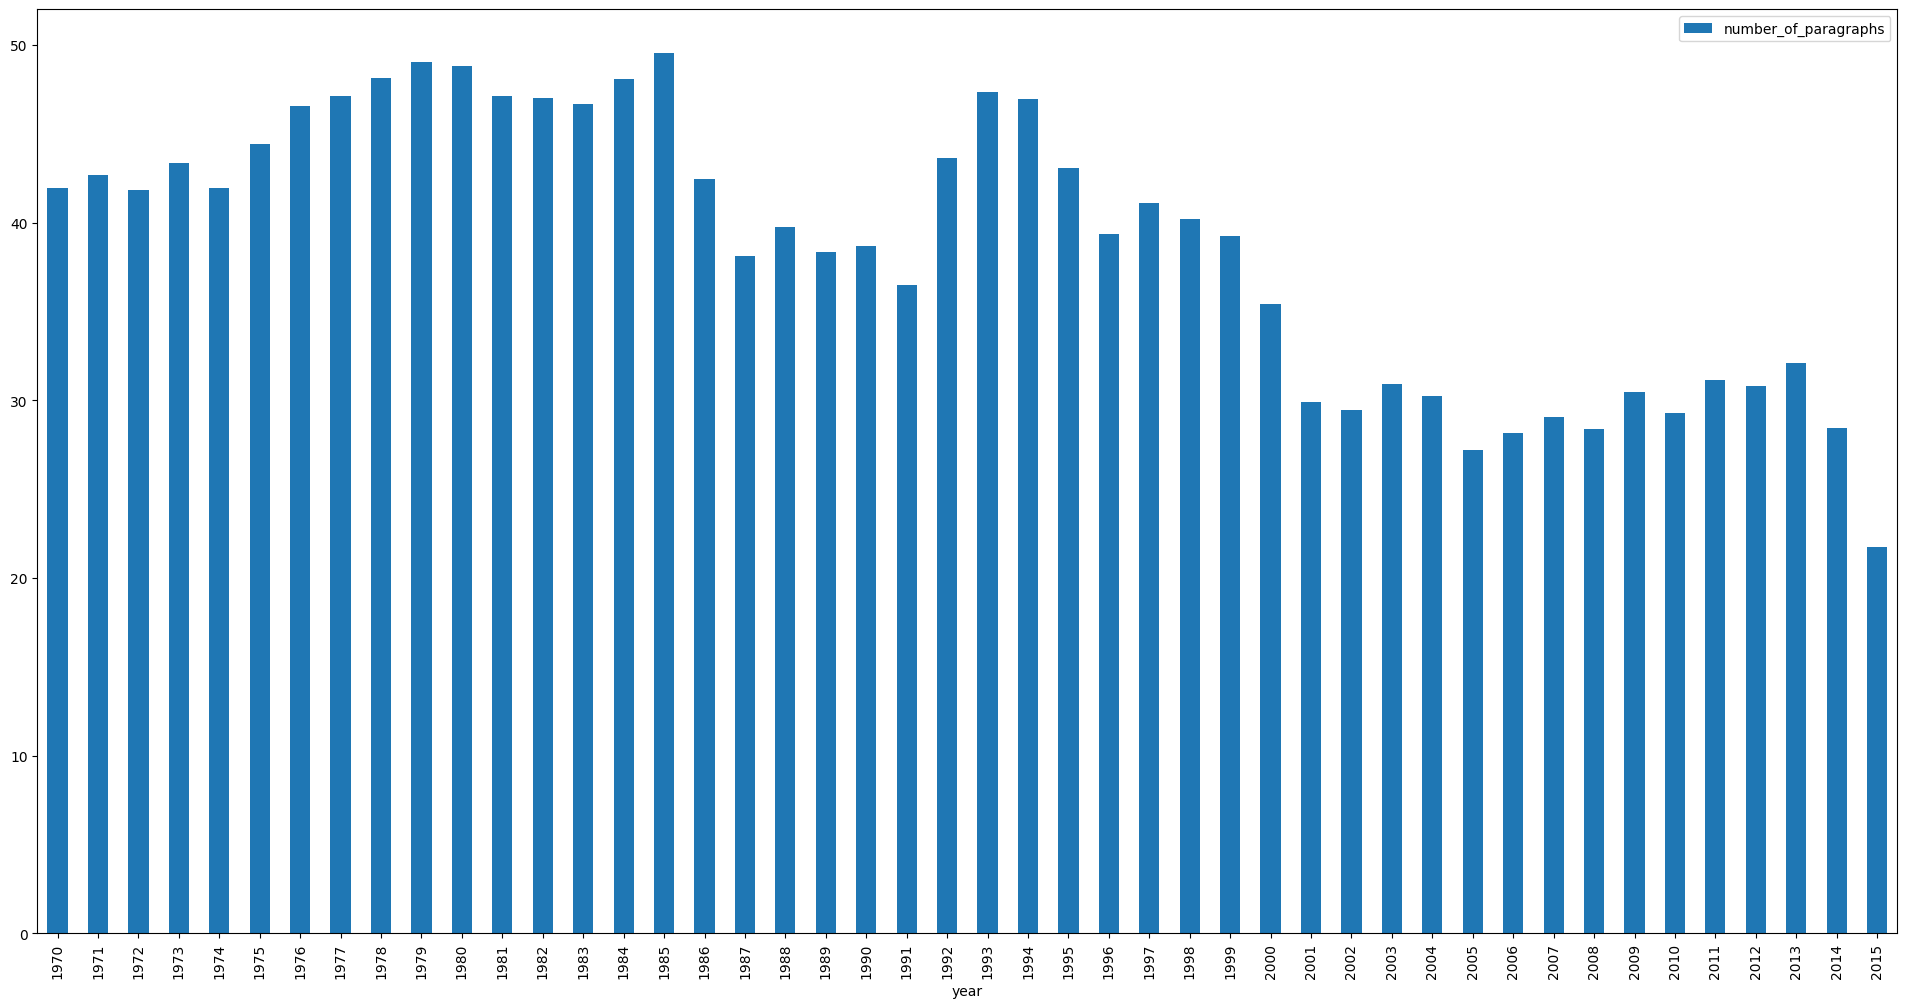

In [6]:
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(24,12))

Avg paragprahs has dropped over the years. (Because number of speakers has increased each year and total time for speeches is also reduced.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(7507, 24611)

In [8]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])
paragraph_df

,text,year
0,﻿It is indeed a pleasure for me and the member...,1989
1,My delegation associates itself with previous ...,1989
2,"As in previous years, my delegation wishes to ...",1989
3,Today we find ourselves at an important crossr...,1989
4,"Developments in southern Africa, and more part...",1989
...,...,...
279071,"In the meantime, the developed countries and t...",2001
279072,"Most recently, Kuwait has contributed $1 milli...",2001
279073,"On a parallel track, Kuwait is contributing to...",2001
279074,Let me close by saying that we look forward to...,2001


In [9]:
tfidf_paragraph_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_paragraph_vectors = tfidf_paragraph_vectorizer.fit_transform(paragraph_df["text"])
tfidf_paragraph_vectors.shape

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

## Nonnegative Matrix Factorization

Easiest way to find a latent structure in the document corpus is the factorization of the document term matrix. Since document term matrix has only positive values we can represent this using linear algebra.

`V (Original Matrix) = W (Factor) * H (Factor)`

In the context of text analytics, both W and H have a meaning. 
- W has the same number of rows as document term matrix. Therefore. it maps documents to topics (document topic matrix).
- H has the same number of columns as features. (topic feature matrix)

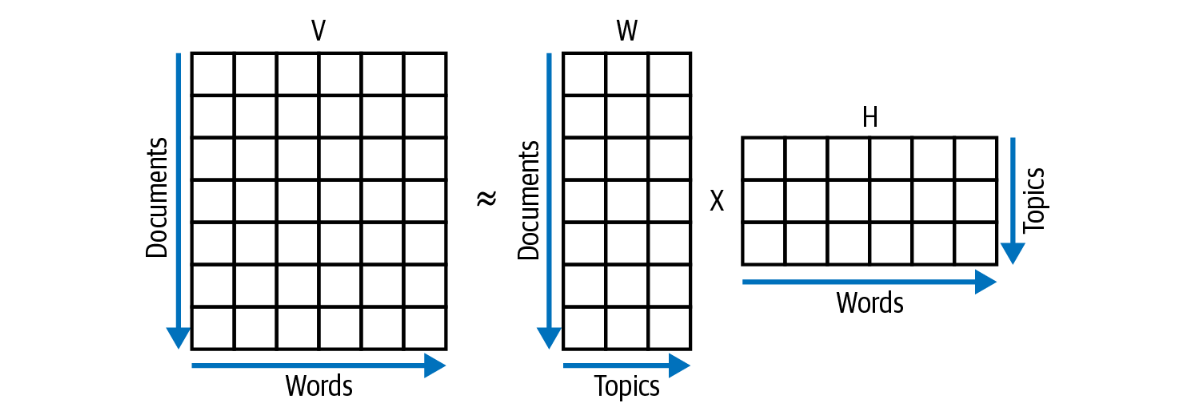

### NMF for Text

In [10]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=10, random_state=42)     # Find 10 topics
W_text_matrix = nmf.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf.components_

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [11]:
W_text_matrix.shape, H_text_matrix.shape

((7507, 10), (10, 24611))

Topics are word distributions. We need to find an interpretation of the topics. We can do so by finding the index of larger values in each row (topic) that we can then use as a lookup index in the vocabulary.

In [12]:
for topic, words in enumerate(H_text_matrix):
    print(topic)
    print(words.sum())

0
196.24312383523545
1
150.01028089860458
2
117.11427916328842
3
106.96336549298404
4
171.29125051669996
5
75.40168578533299
6
90.91478991992845
7
42.991563867481666
8
117.45784536353949
9
87.88104590984298


In [13]:
def display_topics(h, features, no_top_words=5):
    """ Given a H matrix (NMF/SVD component), display the mapping topics """
    
    for topic, words in enumerate(h):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))


display_topics(H_text_matrix, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


We can see we managed to get a glimbse of certain topics, such as middle east issues in topic 3, nuclear disaster and terrorism in topic 00 and 01. Large number of words made contributions lower except for topic 7 `guinea (4.26)`

It would be interesting to find out how big these topics are. Mainly how many documents could be assigned to each topic. Let's do that next

In [14]:
W_text_matrix.sum(axis=0) / W_text_matrix.sum() * 100.0

array([11.05650125, 16.9843506 , 13.68104383, 10.20434952, 11.37918211,
        5.95612865,  7.93030204,  4.17288451, 11.90864274,  6.72661475])

We can see that there are smaller and larger topics but no outliers which is a good indicator. If we ended up with one or two large topics and bunch of outliers we might have need to adjust the topic (n_component) parameter.

### NMF for Paragraphs

In UN general debates, as in many other texts, different topics are often mixed, and it is hard for the topic modeling algorithm to find a common
topic of an individual speech. Especially in longer texts, it happens quite often that documents do not cover just one but several topics. How can we deal with that? One idea is to find smaller entities in the documents that are more coherent from a topic perspective.

In our corpus, paragraphs are a natural subdivision of speeches, and we can assume that the speakers try to stick to one topic within one paragraph. In many documents, paragraphs are a good candidate. Let’s try to calculate their topic models

In [15]:
nmf_paragraph = NMF(n_components=10, random_state=42)
W_paragraph_matrix = nmf_paragraph.fit_transform(tfidf_paragraph_vectors)
H_paragraph_matrix = nmf_paragraph.components_

In [16]:
display_topics(H_paragraph_matrix, tfidf_paragraph_vectorizer.get_feature_names_out())


Topic 00
  nations (5.61)
  united (5.50)
  organization (1.27)
  states (1.02)
  charter (0.93)

Topic 01
  general (2.86)
  session (2.83)
  assembly (2.81)
  mr (1.99)
  president (1.81)

Topic 02
  countries (4.41)
  developing (2.49)
  economic (1.50)
  developed (1.35)
  trade (0.92)

Topic 03
  people (1.36)
  peace (1.33)
  east (1.29)
  middle (1.17)
  palestinian (1.16)

Topic 04
  nuclear (4.93)
  weapons (3.26)
  disarmament (2.01)
  treaty (1.71)
  proliferation (1.46)

Topic 05
  rights (6.48)
  human (6.16)
  respect (1.15)
  fundamental (0.85)
  universal (0.82)

Topic 06
  africa (3.80)
  south (3.30)
  african (1.70)
  namibia (1.38)
  apartheid (1.18)

Topic 07
  security (6.10)
  council (5.87)
  permanent (1.49)
  reform (1.49)
  peace (1.29)

Topic 08
  international (2.03)
  world (1.48)
  community (0.91)
  new (0.76)
  peace (0.67)

Topic 09
  development (4.47)
  sustainable (1.19)
  economic (1.06)
  social (0.99)
  goals (0.94)


Compared to the previous results for topic modeling speeches, we have almost lost all countries or regions except for South Africa and the Middle East. These are due to the regional conflicts that sparked interest in other parts of the world. Topics in the paragraphs like `Human rights`, `international relations`, `developing countries`, `nuclear weapons`, `security council`, `world peace`, and `sustainable development` (the last one probably occurring only lately) look much more reasonable compared to the topics of the speeches. Taking a look at the percentage values of the words, we can
observe that they are dropping much faster, and the topics are more pronounced.

In [17]:
W_paragraph_matrix.sum(axis=0) / W_paragraph_matrix.sum() * 100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

## Latent Semantic Analysis/Indexing

We will now explore using SVD and it has a similar approach to NMF. The picture below shows a high level of detail of what is going on

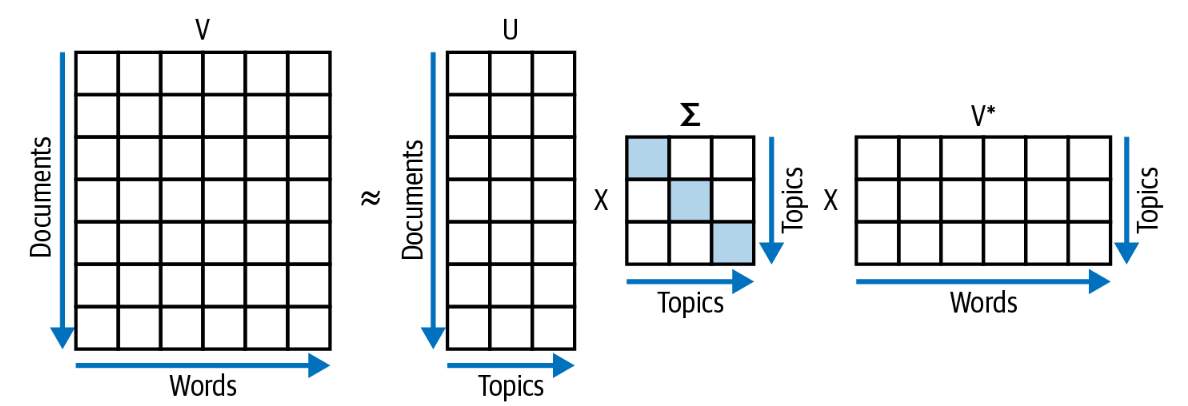

In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10, random_state=42)
W_svd_paragraph_matrix = svd.fit_transform(tfidf_paragraph_vectors)
H_svd_paragraph_matrix = svd.components_

In [19]:
display_topics(H_svd_paragraph_matrix, tfidf_paragraph_vectorizer.get_feature_names_out())


Topic 00
  nations (0.67)
  united (0.65)
  international (0.58)
  peace (0.46)
  world (0.46)

Topic 01
  general (14.25)
  assembly (13.32)
  session (13.19)
  mr (10.22)
  president (8.76)

Topic 02
  countries (20.95)
  development (16.12)
  economic (15.29)
  developing (14.28)
  session (11.14)

Topic 03
  nations (4.43)
  united (4.07)
  development (0.93)
  organization (0.85)
  charter (0.81)

Topic 04
  nuclear (20.20)
  weapons (13.39)
  disarmament (8.64)
  treaty (6.93)
  proliferation (6.06)

Topic 05
  rights (28.41)
  human (27.71)
  nuclear (8.64)
  weapons (6.05)
  respect (4.81)

Topic 06
  africa (9.02)
  south (8.42)
  united (3.91)
  african (3.89)
  namibia (3.56)

Topic 07
  council (14.36)
  security (13.05)
  africa (7.88)
  south (5.65)
  reform (3.77)

Topic 08
  world (39.38)
  peace (29.97)
  international (28.78)
  africa (18.09)
  new (16.47)

Topic 09
  development (59.33)
  sustainable (19.32)
  peace (16.94)
  goals (14.87)
  africa (12.88)


Most of the resulting topics are surprisingly similar to those of the nonnegative matrix factorization. However, the Middle East conflict does not appear as a separate topic this time. As the topic-word mappings can also have negative values, the normalization varies from topic to topic. Only the relative sizes of the words constituting the topics are relevant. 

If we want to determine the sizes of the topics, we now have to take a look at the singular values of the decomposition

In [20]:
svd.singular_values_

array([71.58542396, 39.32344616, 36.48183715, 34.81530053, 33.26015445,
       31.44496673, 29.85898267, 28.66414412, 26.99316039, 26.7319264 ])

The sizes of the topics also correspond quite nicely with the ones from the NMF method for the paragraphs.
Both NMF and SVF have used the document-term matrix (with TF-IDF transformations applied) as a basis for the topic decomposition. Also, the dimensions of the U matrix are identical to those of W; the same is true for V* and H. It is therefore not surprising that both of these methods produce similar and comparable results.

## Latent Dirichlet Allocation

LDA views each document as consisting of different topics. In other words, each document is a mix of different topics. In the same way, topics are mixed from words. To keep the number of topics per document low and to have only a few, important words constituting the topics, LDA initially uses a Dirichlet distribution. This is applied both for assigning topics to documents and for finding words for the topics. The Dirichlet distribution ensures that documents have only a small number of topics and topics are mainly defined by a small number of words.


In [21]:
from sklearn.feature_extraction.text import CountVectorizer


# LDA requires raw counts
count_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(paragraph_df["text"])
count_vectors.shape

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=4)
W_lda_paragraph_matrix = lda.fit_transform(count_vectors)
H_lda_paragraph_matrix = lda.components_

In [23]:
display_topics(H_lda_paragraph_matrix, count_vectorizer.get_feature_names_out())


Topic 00
  general (4.09)
  assembly (3.17)
  session (2.72)
  president (2.03)
  mr (1.85)

Topic 01
  world (2.62)
  human (1.09)
  people (0.84)
  new (0.71)
  peace (0.68)

Topic 02
  nuclear (3.04)
  weapons (2.25)
  disarmament (1.76)
  arms (1.48)
  states (1.29)

Topic 03
  nations (2.58)
  united (2.55)
  international (2.39)
  security (2.21)
  council (1.71)

Topic 04
  countries (4.85)
  economic (2.58)
  developing (1.94)
  international (1.64)
  developed (0.96)

Topic 05
  peace (1.92)
  people (1.35)
  east (1.34)
  middle (1.28)
  israel (1.20)

Topic 06
  states (1.75)
  countries (1.33)
  peace (1.28)
  peoples (1.26)
  relations (1.16)

Topic 07
  united (2.75)
  nations (2.65)
  africa (2.62)
  south (1.77)
  organization (0.98)

Topic 08
  people (1.88)
  republic (1.44)
  government (1.36)
  united (1.15)
  peace (1.05)

Topic 09
  development (2.96)
  nations (2.07)
  united (1.79)
  international (1.57)
  economic (1.11)


It’s interesting to observe that LDA has generated a completely different topic structure compared to the linear algebra methods described earlier. People is the most prominent word in three quite different topics. 

In [24]:
W_lda_paragraph_matrix.sum(axis=0) / W_lda_paragraph_matrix.sum() * 100.0

array([ 9.37044971, 13.16259601,  6.73390729, 12.67691431,  8.34650299,
        9.08440224,  8.7148069 ,  7.83170032,  9.56794441, 14.51077583])

### PyLDAvis: A tool for topic visualisation 

In [25]:
! pip install pyldavis==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyldavis
    Found existing installation: pyLDAvis 3.2.2
    Uninstalling pyLDAvis-3.2.2:
      Successfully uninstalled pyLDAvis-3.2.2


In [26]:
import pyLDAvis.lda_model

lda_display = pyLDAvis.lda_model.prepare(lda, count_vectors, count_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_display)

It's an interactive tool to go over each topic in detail! We can click on the topics and see them in detail

### Wordclouds

In [27]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def wordcloud_topics(h, features, no_top_words=40):
    plt.figure(figsize=(14,16))
    
    for topic, words in enumerate(h):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        
        plt.subplot(5, 2, topic+1)
        
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic}")
        
    plt.tight_layout()
    plt.show()

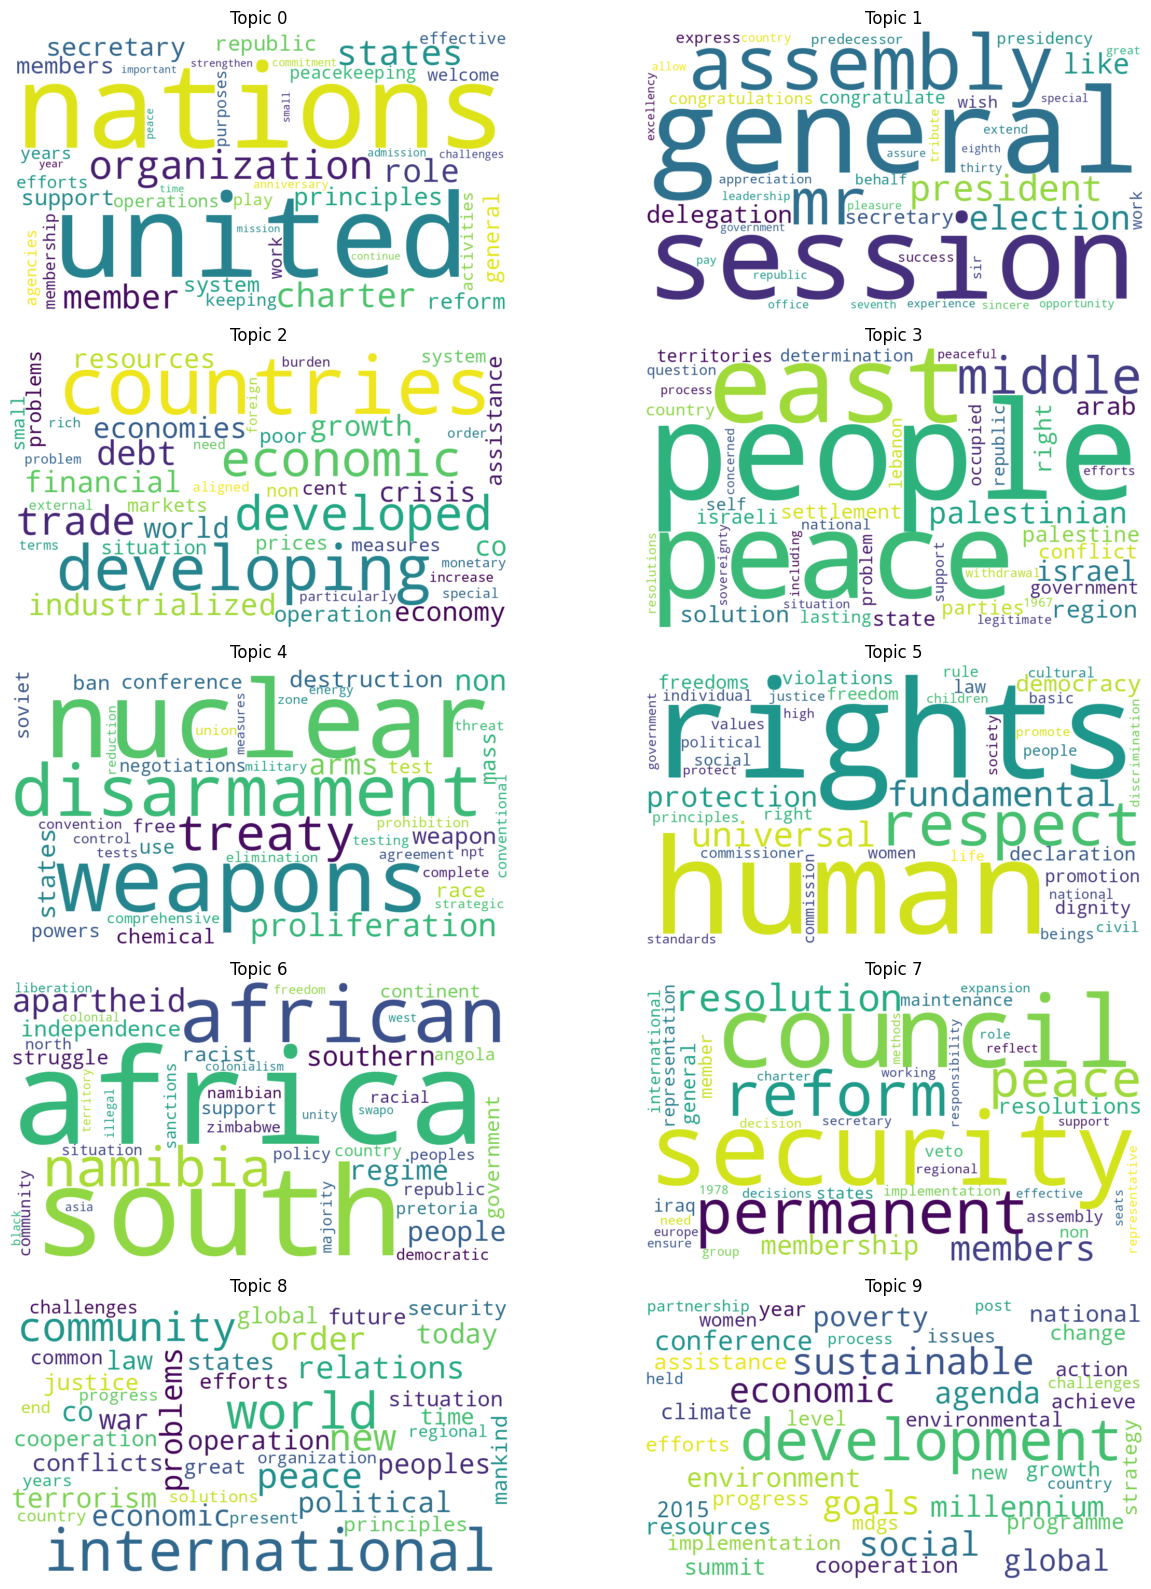

In [29]:
wordcloud_topics(H_paragraph_matrix, tfidf_paragraph_vectorizer.get_feature_names_out())

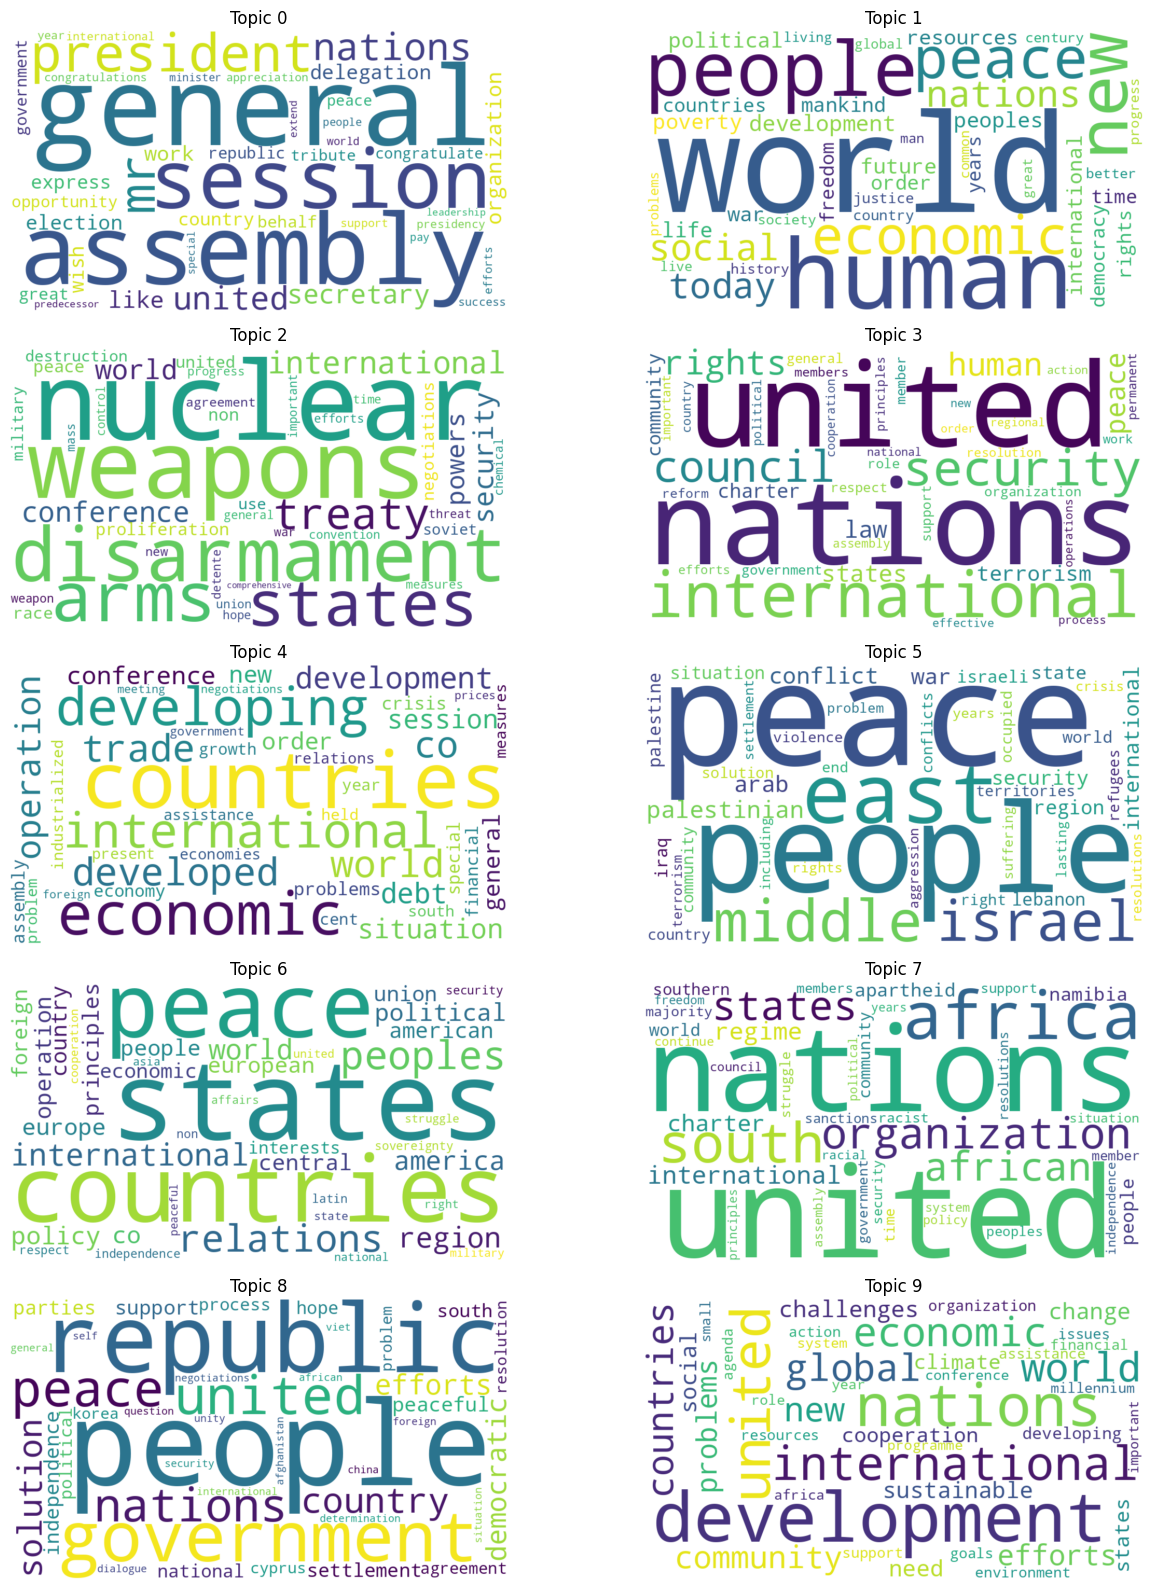

In [30]:
wordcloud_topics(H_lda_paragraph_matrix, count_vectorizer.get_feature_names_out())

## Calculating Topic Distribution of Documents and Time Evolution

As you can see in the analysis at the beginning of the chapter, the speech metadata changes over time. This leads to the interesting question of how the distribution of the topics changes over time

In [31]:
before_1990 = np.array(paragraph_df["year"] < 1990)
after_1990 = ~before_1990

In [32]:
W_paragraph_matrix_early = nmf_paragraph.transform(tfidf_paragraph_vectors[before_1990])
W_paragraph_matrix_late  = nmf_paragraph.transform(tfidf_paragraph_vectors[after_1990])

print(W_paragraph_matrix_early.sum(axis=0) / W_paragraph_matrix_early.sum() * 100.0)
print(W_paragraph_matrix_late.sum(axis=0) / W_paragraph_matrix_late.sum() * 100.0)

[ 9.20962178 10.45479064 12.23762512 11.96923534  7.83419198  6.07025801
 12.22928118  5.87559699 17.43863725  6.68076171]
[11.40231656 10.22115968  8.55802537  8.38145136  5.68415097  8.38983684
  6.28414804 10.25571869 16.42180086 14.40139163]


The result is interesting, as some percentages have changed considerably. Let's take a deeper look into this

In [33]:
from tqdm.auto import tqdm


year_data = []

for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_paragraph.transform(tfidf_paragraph_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0) / W_year.sum() * 100.0))

  0%|          | 0/46 [00:00<?, ?it/s]

In [34]:
topic_names = []
voc = tfidf_paragraph_vectorizer.get_feature_names_out()

for topic in nmf_paragraph.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

<Axes: xlabel='year'>

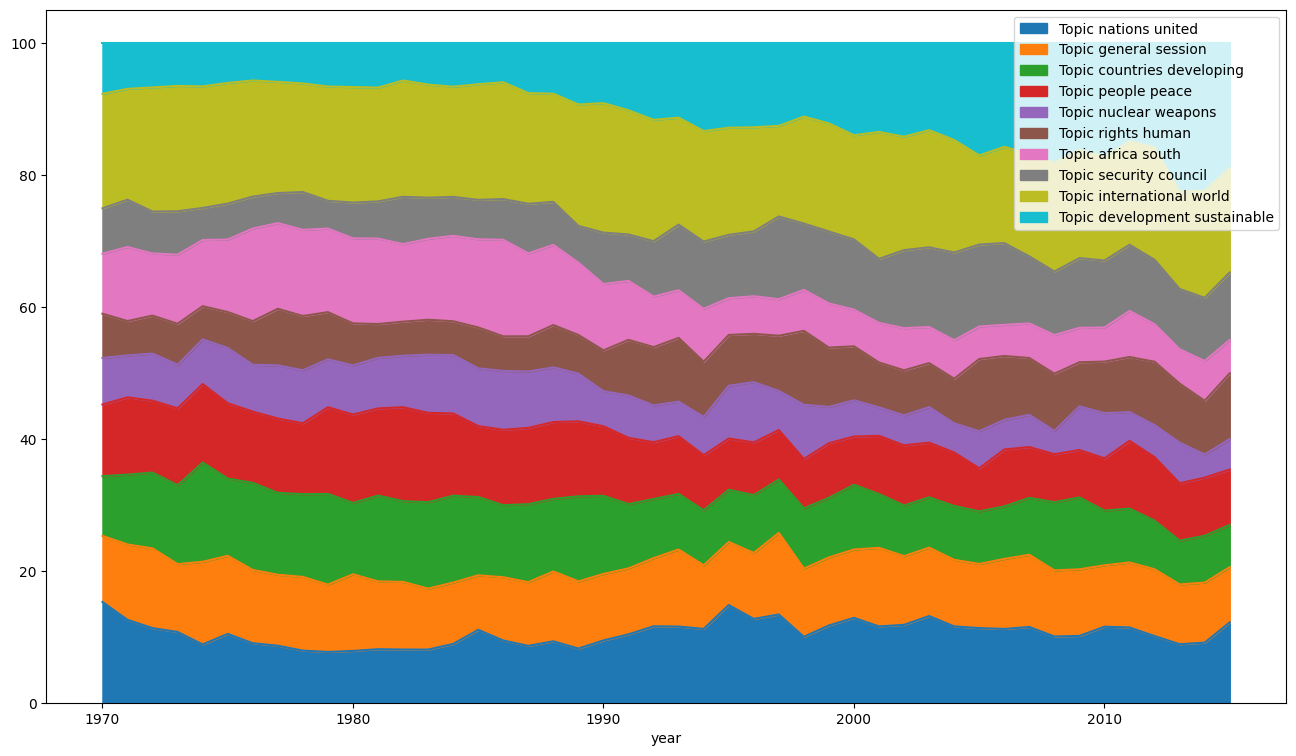

In [35]:
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))

We can recognize that the “sustainable development” topic is continuously increasing, while “south africa” has lost popularity after the apartheid regime ended

## Using Gensim for Topic Modelling

### Preparing Data for Gensim

Unfortunately, the API and the terminology are different from scikit-learn. In the first step, we have to prepare the vocabulary. Gensim has no integrated tokenizer and expects each line of a document corpus to be already tokenized

In [36]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords] for paragraph in paragraph_df["text"]]

In [37]:
from gensim.corpora import Dictionary


dict_gensim_paragraphs = Dictionary(gensim_paragraphs) 
dict_gensim_paragraphs.filter_extremes(no_below=5, no_above=0.7)
bow_gensim_paragraphs = [dict_gensim_paragraphs.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [38]:
from gensim.models import TfidfModel


tfidf_gensim_paragraphs = TfidfModel(bow_gensim_paragraphs)
vectors_gensim_paragraphs = tfidf_gensim_paragraphs[bow_gensim_paragraphs]

### NMF

In [39]:
from gensim.models.nmf import Nmf


nmf_gensim_paragraphs = Nmf(
    vectors_gensim_paragraphs, num_topics=10, id2word=dict_gensim_paragraphs, kappa=0.1, eval_every=5, random_state=42
) 

In [40]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [41]:
display_topics_gensim(nmf_gensim_paragraphs)


Topic 00
  people (0.01)
  peace (0.01)
  security (0.01)
  republic (0.01)
  country (0.01)

Topic 01
  international (0.02)
  world (0.01)
  political (0.01)
  new (0.01)
  law (0.01)

Topic 02
  nuclear (0.04)
  weapons (0.03)
  disarmament (0.01)
  treaty (0.01)
  arms (0.01)

Topic 03
  nations (0.02)
  united (0.02)
  human (0.02)
  rights (0.02)
  organization (0.01)

Topic 04
  development (0.02)
  sustainable (0.01)
  goals (0.01)
  global (0.01)
  agenda (0.01)

Topic 05
  economic (0.02)
  co (0.02)
  operation (0.02)
  countries (0.02)
  session (0.02)

Topic 06
  countries (0.01)
  developing (0.01)
  debt (0.01)
  america (0.01)
  central (0.01)

Topic 07
  general (0.02)
  mr (0.02)
  assembly (0.02)
  secretary (0.01)
  session (0.01)

Topic 08
  east (0.02)
  middle (0.02)
  palestinian (0.02)
  solution (0.02)
  israel (0.01)

Topic 09
  africa (0.04)
  south (0.03)
  african (0.02)
  apartheid (0.01)
  namibia (0.01)


NMF is also a statistical method, so the results are not supposed to be identical to the ones that we calculated with scikit-learn, but they are similar enough. Gensim has code for calculating the coherence score for topic models, a quality indicator. 

Coherence models are used in natural language processing (NLP) and specifically in the context of topic modeling to evaluate the quality and interpretability of the topics generated by a given topic model. Topic models produce a set of topics represented as distributions over words. Coherence models aim to measure how interpretable and coherent these topics are. It is a measure of the semantic similarity among the top words within a topic. Higher coherence values indicate that the words in a topic are more related and provide a clearer theme or subject.

Coherence models aid in selecting the optimal number of topics for a topic model or in fine-tuning the model's parameters to generate more meaningful topics that better represent the underlying themes within a corpus of text data.

In [42]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_paragraphs_coherence = CoherenceModel(
    model=nmf_gensim_paragraphs, texts=gensim_paragraphs, dictionary=dict_gensim_paragraphs, coherence='c_v'
)
nmf_gensim_paragraphs_coherence_score = nmf_gensim_paragraphs_coherence.get_coherence()
print(nmf_gensim_paragraphs_coherence_score)

0.6442420103288301


The score varies with the number of topics. If you want to find the optimal number of topics, a frequent approach is to run NMF for several different values, calculate the coherence score, and take the number of topics that maximizes the score.

### LDA

In [43]:
from gensim.models import LdaModel


lda_gensim_paragraphs = LdaModel(
    corpus=bow_gensim_paragraphs, 
    id2word=dict_gensim_paragraphs, 
    chunksize=2000, 
    alpha='auto', 
    eta='auto', 
    iterations=400, 
    num_topics=10, 
    passes=20, 
    eval_every=None, 
    random_state=42
)

display_topics_gensim(lda_gensim_paragraphs)


Topic 00
  international (0.03)
  new (0.02)
  world (0.02)
  development (0.02)
  global (0.01)

Topic 01
  terrorism (0.03)
  cooperation (0.02)
  support (0.02)
  states (0.01)
  international (0.01)

Topic 02
  nations (0.11)
  united (0.11)
  general (0.05)
  assembly (0.03)
  organization (0.03)

Topic 03
  countries (0.13)
  economic (0.08)
  development (0.05)
  developing (0.04)
  social (0.03)

Topic 04
  africa (0.03)
  people (0.03)
  south (0.02)
  east (0.02)
  middle (0.02)

Topic 05
  peace (0.04)
  security (0.04)
  international (0.02)
  council (0.02)
  states (0.02)

Topic 06
  country (0.07)
  government (0.07)
  people (0.06)
  republic (0.04)
  democratic (0.03)

Topic 07
  human (0.12)
  rights (0.10)
  law (0.04)
  justice (0.03)
  democracy (0.03)

Topic 08
  conference (0.07)
  nuclear (0.05)
  weapons (0.05)
  disarmament (0.03)
  convention (0.03)

Topic 09
  world (0.03)
  time (0.01)
  years (0.01)
  war (0.01)
  today (0.01)


Gensim also allows us to calculate the perplexity score of an LDA model. Perplexity measures how well a probability model predicts a sample.

In [44]:
lda_gensim_paragraphs.log_perplexity(vectors_gensim_paragraphs)

-9.626107990752669

In [45]:
lda_gensim_paragraphs_coherence = CoherenceModel(
    model=lda_gensim_paragraphs, texts=gensim_paragraphs, dictionary=dict_gensim_paragraphs, coherence='c_v'
)
lda_gensim_paragraphs_coherence_score = lda_gensim_paragraphs_coherence.get_coherence()
print(lda_gensim_paragraphs_coherence_score)

0.6223596863015317


Despite its runtime, LDA didn't perform better than NMF.

Calculating the coherence score of the individual topics for LDA is even easier, as it is directly supported by the LDA model.

In [46]:
top_topics = lda_gensim_paragraphs.top_topics(vectors_gensim_paragraphs, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.8115.


In [47]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-1.4342610791053034, 'peace security international council states'),
 (-1.43651527753348, 'nations united general assembly organization'),
 (-1.4517680603924448, 'terrorism cooperation support states international'),
 (-1.53176197242438, 'countries economic development developing social'),
 (-1.7791375889891712, 'international new world development global'),
 (-1.9017023911594813, 'country government people republic democratic'),
 (-2.0368100644373266, 'africa people south east middle'),
 (-2.1050690388609246, 'conference nuclear weapons disarmament convention'),
 (-2.206376089194751, 'human rights law justice democracy'),
 (-2.231346939619871, 'world time years war today')]

Coherence scores for topic models can easily be calculated using Gensim. The absolute values are difficult to interpret, but varying the methods (NMF versus LDA) or the number of topics can give us ideas about which way we want to proceed in our topic models. Coherence scores and coherence models are a big advantage of Gensim, as they are not (yet) included in scikit-learn.



### Finding Optimal Number of Topics

We have always worked with 10 topics. So far we have not compared the quality of this topic model to different ones with a lower or higher number of topics. We want to find the optimal number of topics in a structured way without having to go into the interpretation of each constellation. It turns out there is a way to achieve this. The “quality” of a topic model can be measured by the previously introduced coherence score. To find the best coherence score, we will now calculate it for a different number of topics with an LDA model. We will try to find the highest score, which should give us the optimal number of topics

NOTE: Below code piece takes too long to run so only run if you have the time to do so.

In [ ]:
from gensim.models.ldamulticore import LdaMulticore


lda_paragraphs_model_n = []

for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(
        corpus=bow_gensim_paragraphs, 
        id2word=dict_gensim_paragraphs, 
        chunksize=10000,
        eta='auto', 
        iterations=400, 
        num_topics=n, 
        passes=20, 
        eval_every=None,
        workers=2,
        random_state=42
    )
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_paragraphs, dictionary=dict_gensim_paragraphs, coherence='c_v')
    lda_paragraphs_model_n.append((n, lda_model, lda_coherence.get_coherence()))

  0%|          | 0/16 [00:00<?, ?it/s]

Typically the score grows with the number of topics. Taking too many topics makes interpretation difficult.

In [ ]:
pd.DataFrame(lda_paragraphs_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16, 9))

In [ ]:
display_topics_gensim(lda_paragraphs_model_n[12][1])

The higher coherence measure does not necessarily mean a more obvious interpretation. Relying solely on coherence scores can be dangerous if the number of topics gets too large. Although in theory higher coherence should contribute to better interpretability, it is often a trade-off, and choosing smaller numbers of topics can make life easier.

### Hierarchical Dirichlet Process

As it’s difficult to estimate the “correct” number of topics, we are now taking a look at an approach that creates hierarchical models and does not need a fixed number of topics as a parameter

In [48]:
from gensim.models import HdpModel


hdp_gensim_paragraphs = HdpModel(corpus=bow_gensim_paragraphs, id2word=dict_gensim_paragraphs)

In [49]:
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim_paragraphs.print_topics(num_topics=20, num_words=8)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.012,united,0.011,nations,0.010,peace,0.010,international,0.009,people,0.007,security,0.007,states,0.006,world
1,0.016,countries,0.013,international,0.013,development,0.011,economic,0.011,nations,0.010,world,0.009,united,0.007,developing
2,0.015,nations,0.013,united,0.012,international,0.010,world,0.008,human,0.007,peace,0.007,rights,0.006,security
3,0.015,general,0.014,nations,0.014,united,0.012,assembly,0.011,session,0.009,international,0.008,mr,0.007,world
4,0.011,united,0.011,nations,0.011,international,0.008,world,0.007,peace,0.007,countries,0.006,states,0.006,security
5,0.011,nations,0.011,united,0.011,international,0.008,world,0.008,countries,0.007,peace,0.006,states,0.006,security
6,0.011,nations,0.011,international,0.011,united,0.009,countries,0.009,world,0.007,peace,0.006,development,0.006,economic
7,0.011,nations,0.011,united,0.011,international,0.008,world,0.008,countries,0.007,peace,0.006,states,0.006,development
8,0.011,nations,0.011,united,0.011,international,0.008,world,0.008,countries,0.007,peace,0.006,states,0.006,security
9,0.011,nations,0.011,united,0.011,international,0.008,world,0.008,countries,0.007,peace,0.006,states,0.005,security


In [50]:
hdp_gensim_paragraphs.show_topic(0, topn=10)

[('united', 0.011758378957443938),
 ('nations', 0.01066788342072235),
 ('peace', 0.010444420204224071),
 ('international', 0.010214875906174516),
 ('people', 0.008541100239182814),
 ('security', 0.007158102922886887),
 ('states', 0.006974691905277395),
 ('world', 0.005953637799335032),
 ('countries', 0.005411751970046445),
 ('south', 0.004798503134436127)]

In [51]:
for topic in range(0, 50):
    print("\nTopic %02d" % topic)
    for (word, prob) in hdp_gensim_paragraphs.show_topic(topic, topn=10):
        print("  %s (%2.2f)" % (word, prob))


Topic 00
  united (0.01)
  nations (0.01)
  peace (0.01)
  international (0.01)
  people (0.01)
  security (0.01)
  states (0.01)
  world (0.01)
  countries (0.01)
  south (0.00)

Topic 01
  countries (0.02)
  international (0.01)
  development (0.01)
  economic (0.01)
  nations (0.01)
  world (0.01)
  united (0.01)
  developing (0.01)
  new (0.01)
  states (0.01)

Topic 02
  nations (0.01)
  united (0.01)
  international (0.01)
  world (0.01)
  human (0.01)
  peace (0.01)
  rights (0.01)
  security (0.01)
  countries (0.01)
  people (0.01)

Topic 03
  general (0.01)
  nations (0.01)
  united (0.01)
  assembly (0.01)
  session (0.01)
  international (0.01)
  mr (0.01)
  world (0.01)
  president (0.01)
  peace (0.01)

Topic 04
  united (0.01)
  nations (0.01)
  international (0.01)
  world (0.01)
  peace (0.01)
  countries (0.01)
  states (0.01)
  security (0.01)
  people (0.01)
  development (0.00)

Topic 05
  nations (0.01)
  united (0.01)
  international (0.01)
  world (0.01)
  coun

Topic models focus on uncovering the topic structure of a large corpus of documents. As all documents are modeled as a mixture of different topics, they are not well-suited for assigning documents to exactly one topic. This can be achieved using clustering